# Evaluación de nuestro RAG

In [27]:
from langchain_mistralai import ChatMistralAI
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_chroma import Chroma

from chatbot import Chatbot

import pandas as pd
from tqdm import tqdm
import time
import warnings
from dotenv import load_dotenv
import os

load_dotenv()
MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
warnings.filterwarnings("ignore", category=FutureWarning)

El modelo que vamos a usar para las evaluaciones y nuestro RAG

In [28]:
llm = ChatMistralAI(
    model="mistral-small-latest", 
    mistral_api_key=MISTRAL_API_KEY,
    temperature=0, 
    random_seed=12345
)

chatbot = Chatbot(chroma_directory="../chroma")

Cargamos una muestra de nuestro dataset

In [29]:
df = pd.read_csv("preguntas_mistral_plus.csv", on_bad_lines="skip")
df_shuffle = df.sample(frac=1, random_state=12345)
test_sample = df_shuffle.head(5)

In [30]:
test_sample

,Pregunta,Respuesta,Contexto,Recurso
75,¿Hasta cuándo se ha ampliado el plazo de caduc...,El plazo de caducidad de las tarjetas del Bono...,"Adicionalmente, se prevé la concesión directa ...",..\my_data\BOE-A-2024-23422.pdf
435,¿Qué tipo de gastos relacionados con la atenci...,Los gastos subvencionables incluyen arrendamie...,i) Puesta en marcha de servicios especializado...,..\my_data\BOE-A-2025-2414.pdf
458,¿Qué medidas se han adoptado para ayudar a las...,"Se aprobaron el Real Decreto-ley 6/2024, de 5 ...","de titularidad de la Administración local, dif...",..\my_data\BOE-A-2025-6353.pdf
148,¿Qué permisos adicionales se han establecido p...,Las personas socias trabajadoras o de trabajo ...,solicitud de los interesados en la que se moti...,..\my_data\BOE-A-2024-23422.pdf
206,¿Dónde puedo encontrar la información oficial ...,La información oficial sobre las ayudas dispon...,* Campos obligatorios TIPO DE AYUDA SOLICITA...,..\my_data\BOE-A-2024-23852.pdf


## Configuración de los agentes críticos

- **Accuracy**: Grado de acierto de la respuesta final
- **Faithfulness**: Si la respuesta se basa exclusivamente en los documentos recuperados
- **Groundedness**: Si la pregunta puede ser respondida con el contexto aportado
- **Relevance**: Si los docs recuperados tienen que ver con la pregunta

In [31]:
accuracy_prompt = """
Evalúa la exactitud de la siguiente respuesta generada por un sistema RAG. Compara la respuesta generada con la respuesta esperada, e indica en qué medida responde correctamente.

Respuesta esperada: {respuesta_esperada}
Respuesta generada: {respuesta_generada}

Del 0 al 5, ¿qué tan correcta es la respuesta?
- 0 = Totalmente incorrecta
- 5 = Completamente correcta y precisa

---
Devuelve SOLO el número.
"""

faithfulness_prompt = """
Evalúa si la respuesta generada se basa únicamente en la información proporcionada en los documentos. No debe contener invenciones o afirmaciones que no estén respaldadas por los textos.

Documentos recuperados: {documentos}
Respuesta generada: {respuesta}

Del 0 al 5, ¿qué tan fiel es la respuesta a los documentos?
- 0 = Contiene información inventada o irrelevante
- 5 = Totalmente fiel al contenido de los documentos

---
Devuelve SOLO el número.
"""

groundedness_prompt = """
Evalúa si la respuesta generada está bien fundamentada en el contenido de los documentos proporcionados. La respuesta debe usar la evidencia relevante de forma clara y apropiada.

Documentos recuperados: {documentos}
Respuesta generada: {respuesta}

Del 0 al 5, ¿qué tan bien fundamentada está la respuesta en los documentos?
- 0 = No utiliza los documentos o lo hace de forma incorrecta
- 5 = Uso excelente y preciso de la información contenida

---
Devuelve SOLO el número.
"""

relevance_prompt = """
Evalúa qué tan relevantes son los documentos recuperados con respecto a la pregunta formulada. Considera si aportan información útil para construir una respuesta adecuada.

Pregunta: {pregunta}
Documentos recuperados: {documentos}

Del 0 al 5, ¿qué tan relevantes son los documentos para la pregunta?
- 0 = Irrelevantes
- 5 = Totalmente relevantes y adecuados

---
Devuelve SOLO el número.
"""

In [32]:
def get_response(question: str, chatbot: Chatbot):
    results = chatbot.get_retriever().batch([question])
    context = "\n\n---\n\n".join([doc.page_content for doc in results[0]]) # contexto
    
    response = chatbot.answer_query2(question, context)

    return response, context

In [33]:
columns = [
    "pregunta", "respuesta esperada", "respuesta generada", 
    "accuracy", "faithfulness", 
    "groundedness", "relevance"
]

eval_rag = []

In [34]:
for index, row in tqdm(test_sample.iterrows(), total=len(test_sample)):
    pregunta = row["Pregunta"]
    respuesta = row["Respuesta"]
    contexto = row["Contexto"]   

    respuesta_generada, docs_recuperados = get_response(pregunta, chatbot)  

    time.sleep(5) # Espera para evitar sobrecargar el servidor

    evaluations = {
        "accuracy": accuracy_prompt.format(respuesta_esperada=respuesta, respuesta_generada=respuesta_generada),
        "faithfulness": faithfulness_prompt.format(documentos=docs_recuperados, respuesta=respuesta_generada),
        "groundedness": groundedness_prompt.format(documentos=docs_recuperados, respuesta=respuesta_generada),
        "relevance": relevance_prompt.format(pregunta=pregunta, documentos=docs_recuperados)
    }    

    try:

        eval_row = {
            "pregunta": pregunta,
            "respuesta esperada": respuesta,
            "respuesta generada": respuesta_generada            
        }

        for criterion, evaluation in evaluations.items():            

            chain = llm | StrOutputParser()
            score = chain.invoke(evaluation)

            eval_row[criterion] = int(score)

            time.sleep(5) # Espera para evitar sobrecargar el servidor

        eval_rag.append(eval_row)
            
    except Exception as e:
        continue

 80%|████████  | 4/5 [01:52<00:28, 28.12s/it]


HTTPStatusError: Error response 429 while fetching https://api.mistral.ai/v1/chat/completions: {"message":"Requests rate limit exceeded"}

In [35]:
eval_rag_df = pd.DataFrame(eval_rag, columns=columns)
eval_rag_df

,pregunta,respuesta esperada,respuesta generada,accuracy,faithfulness,groundedness,relevance
0,¿Hasta cuándo se ha ampliado el plazo de caduc...,El plazo de caducidad de las tarjetas del Bono...,El plazo de caducidad de las tarjetas del Bono...,3,5,5,4
1,¿Qué tipo de gastos relacionados con la atenci...,Los gastos subvencionables incluyen arrendamie...,Los gastos relacionados con la atención direct...,3,5,4,3
2,¿Qué medidas se han adoptado para ayudar a las...,"Se aprobaron el Real Decreto-ley 6/2024, de 5 ...",Para ayudar a las personas afectadas por la DA...,3,5,4,4


In [36]:
scores_columns = ["accuracy", "faithfulness", "groundedness", "relevance"]
scores_df = round(eval_rag_df[scores_columns].mean(),2)
scores_df = scores_df.to_frame().transpose()
scores_df

,accuracy,faithfulness,groundedness,relevance
0,3.0,5.0,4.33,3.67


In [37]:
%matplotlib inline

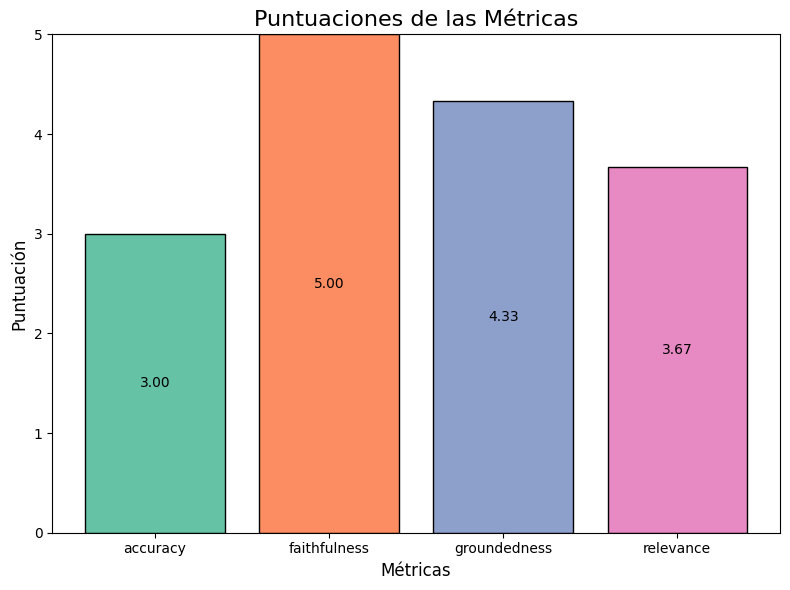

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transponer el DataFrame para facilitar el plot
data = scores_df.transpose()
data.columns = ["Puntuación"]

# Colores distintos para cada barra
colors = sns.color_palette("Set2", n_colors=len(data))

# Crear la figura
plt.figure(figsize=(8, 6))

# Crear el gráfico de barras
bars = plt.bar(data.index, data["Puntuación"], color=colors, edgecolor='black')

# Añadir etiquetas centradas dentro de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{height:.2f}",
        ha='center',
        va='center',
        fontsize=10,
        color='black'
    )

# Personalizar la gráfica
plt.title("Puntuaciones de las Métricas", fontsize=16)
plt.xlabel("Métricas", fontsize=12)
plt.ylabel("Puntuación", fontsize=12)
plt.ylim(0, 5)
plt.xticks(rotation=0)  
plt.tight_layout()

# Mostrar la gráfica
plt.show()

